[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://docs.langchain.com/oss/python/langgraph/use-graph-api#map-reduce-and-the-send-api).

In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [ ]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/riyaa/Documents/code/mat496/langgraphmod4/studio/.env", override=True) #path to my env folder

True

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", 
    temperature=0.7,
)

premises_prompt = """Generate a list of 3 different story premises that are all related to this overall theme: {theme}. 
Each premise should be unique and compelling, suitable for a short story or novella."""

plot_prompt = """Based on this story premise: {premise}

Generate a detailed plot idea including:
- Main conflict
- Key plot points
- Potential character arcs
- Climax suggestion

Be creative and engaging."""

best_story_prompt = """Below are different plot ideas all related to the theme: {theme}

Plot Ideas:
{plots}

Evaluate all these plot ideas and select the best one. Return the ID of the best plot idea, starting with 0 as the ID for the first plot. 
Consider originality, emotional impact, and storytelling potential."""

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [3]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Premises(BaseModel):
    premises: list[str]

class BestPlot(BaseModel):
    id: int
    
class OverallState(TypedDict):
    theme: str
    premises: list
    plots: Annotated[list, operator.add]
    selected_story: str

Generate subjects for jokes.

In [4]:
def generate_premises(state: OverallState):
    """Generate multiple story premises based on the theme"""
    prompt = premises_prompt.format(theme=state["theme"])
    response = llm.with_structured_output(Premises).invoke(prompt)
    return {"premises": response.premises}

Here is the magic: we use the  [Send](https://docs.langchain.com/oss/python/langgraph/graph-api/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [5]:
from langgraph.types import Send

def continue_to_plots(state: OverallState):
    """Fan out to generate plots for each premise"""
    return [Send("generate_plot", {"premise": p}) for p in state["premises"]]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [6]:
class PlotState(TypedDict):
    premise: str

class Plot(BaseModel):
    plot: str

def generate_plot(state: PlotState):
    """Generate a detailed plot idea for a given premise"""
    prompt = plot_prompt.format(premise=state["premise"])
    response = llm.with_structured_output(Plot).invoke(prompt)
    return {"plots": [response.plot]}

### Best joke selection (reduce)

Now, we add logic to pick the best joke.

In [7]:
def best_plot(state: OverallState):
    """Select the best plot from all generated plots"""
    plots = "\n\n---\n\n".join([f"Plot {i}:\n{plot}" for i, plot in enumerate(state["plots"])])
    prompt = best_story_prompt.format(theme=state["theme"], plots=plots)
    response = llm.with_structured_output(BestPlot).invoke(prompt)
    return {"selected_story": state["plots"][response.id]}

## Compile

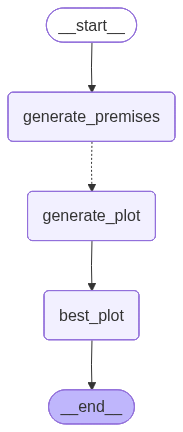

In [8]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START

# Construct the graph
graph = StateGraph(OverallState)
graph.add_node("generate_premises", generate_premises)
graph.add_node("generate_plot", generate_plot)
graph.add_node("best_plot", best_plot)
graph.add_edge(START, "generate_premises")
graph.add_conditional_edges("generate_premises", continue_to_plots, ["generate_plot"])
graph.add_edge("generate_plot", "best_plot")
graph.add_edge("best_plot", END)

# Compile the graph
app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
for s in app.stream({"theme": "time travel and consequences"}):
    print(s)

{'generate_premises': {'premises': ['A historian travels back in time to prevent a major historical disaster, but inadvertently creates a worse catastrophe.', 'A group of friends discovers a time machine and uses it for personal gain, only to find their actions are unraveling the fabric of reality.', 'In a future where time travel is common, a temporal detective investigates a series of paradoxes that threaten to erase his own existence.']}}
{'generate_plot': {'plots': ["A group of college friends stumble upon a time machine hidden in the basement of their university's physics building. Initially, they use it for trivial things: acing exams, winning sports bets, and avoiding embarrassing social situations. The main conflict arises when one of them, driven by greed, decides to manipulate historical events for financial gain, creating paradoxes and unforeseen consequences that begin to destabilize their present. Key plot points include: 1) The discovery of the time machine and initial ex

## Studio

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

Let's load the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.